# Final Version
# De novo peptide spectrum interpretation

This code will read data from an tsv file, this file contains associations of the name of a tandem spectra and their corresponding amino acids sequence. I will find the corresponding spectra in an mzML file and create a Dataframe from matches.
<br>
This code will then find the shortest spectra <b>visualize</b> it and <b>identify</b> the presumably correct peaks based on the match.
This programs purpose is to recreate this spectra annotation as faithfully as possible just based on the distances between the peaks (which are assumed to be y-ions).
<br>
To achieve this the code will create a distance matrix and score every single distance between peaks and which of them could fit an amino acids or pair of amino acids between them. Using this distance matrix the code will find every single possible peptide. These are then given a confidence score referring to their likelyhood of being the true peptide. This confidence score is adapted from the 2003 paper by David Tabb named DirecTag https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2810657/
<br>
This approach of identifying peptides is called <b>DeNovo </b> and this code is based on the instructions by Nick Webb (https://www.weddslist.com/ms/tandem.html)

I will investigate how well my programs predict the amino acid sequence by comparing the actual vs predicted sequence AND how well my confidence score works.

At the end, in order to check my results, I will use the pyteomics.pylab_aux module to test my annotations and visualize the spectrum


In [1]:
# IMPROVEMENTS for optimization and readability
# TODO find ways to optimize peak picking to decrease information loss
# TODO remove the to_csv then read_csv part in build_dm
# TODO add arguments to functions so they dont use outside variables
# TODO remove redundant calculations from find_closest_aa (closeness_list)

In [2]:
# basic dependencies and useful math/organization
import pandas as pd
import numpy as np
import math
import random
from scipy.stats import chi2

# to read mzML files
from pyteomics import mzml

# to visualize MS/MS and obtain ground truth
import matplotlib.pyplot as plt
import seaborn as sns
from pyteomics import pylab_aux as pa
from pyteomics import mass

# to find peaks
from scipy.signal import find_peaks

## reading the files

In [3]:
# file that contains the associations between tandem spectra name and amino acids sequence
df = pd.read_csv("../data/psm_a.tsv", sep="\t")

In [4]:
# file that contains the amino acids and their weights
aa = pd.read_csv("../data/single_double_amino_acids.csv")
# beware that leucine (L) and isoleucine (I) weight the same and are indistinguishable

In [5]:
mz_path = '../data/2015-05-19_MRC5_a.mzML'

In [6]:
# this creates a dictionary of matches between the mzMl file and the psm_a.tsv
# this should only return MS/MS where we have the Peptide sequence already identified.
matches = []
plotting_dict = None
with mzml.MzML(mz_path) as reader:
    for spectrum in reader:
        # looking for the first match between the 2 files
        for name in df["Spectrum"]:
            if name in spectrum.get('spectrum title') :
                # Extract relevant information
                matches.append([spectrum,df[df["Spectrum"] == name]["Peptide"].sum(),
                               df[df["Spectrum"] == name]["Hyperscore"].sum()])
m_df = (pd.DataFrame(matches, columns=["Spectrum","Peptide","Hyperscore"])
    .sort_values(by = ["Hyperscore"], axis=0, ascending= False)
    .reset_index(drop=True))

## deciding on which Peptide to identify

In [7]:
# this is the shortest peptide in the list
print(min(m_df["Peptide"], key = len))
print(m_df[m_df["Peptide"] == str(min(m_df["Peptide"], key = len))])

# index number of the peptide we want to identify in m_df
pep_loc = 7103



HELIEFR
                                               Spectrum  Peptide  Hyperscore
7103  {'index': 11186, 'id': 'controllerType=0 contr...  HELIEFR      22.679


In [8]:
# collecting the data in variables
peptide = m_df["Peptide"].iloc[pep_loc]
print("Peptide sequence:", peptide)
mz_array = m_df["Spectrum"].iloc[pep_loc]['m/z array']
intensity_array = m_df["Spectrum"].iloc[pep_loc]['intensity array']
precursor_mz = m_df["Spectrum"].iloc[pep_loc]['precursorList']['precursor'][0]['selectedIonList']['selectedIon'][0]['selected ion m/z']
plotting_dict = {'m/z array': mz_array, 'intensity array': intensity_array}
# I am subtracting 1.00782 because that is the mass of the extra proton that gives the precursor a double charge
# every other y ion has just one extra proton
original_peptide_mass = precursor_mz*2 - 1.00782

Peptide sequence: VATWFNQPAR


## Finding Peaks
using sci_peak

In [9]:
# converting to dataframe for simplicity?
s1 = pd.DataFrame(plotting_dict)

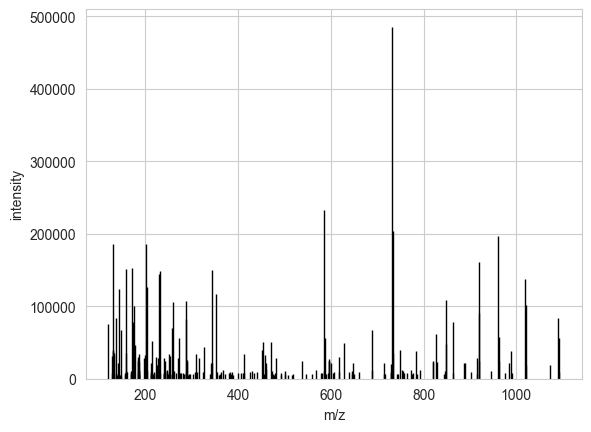

<Figure size 1200x600 with 0 Axes>

In [10]:
pa.plot_spectrum(plotting_dict)
plt.figure(figsize=(12,6))
plt.show()

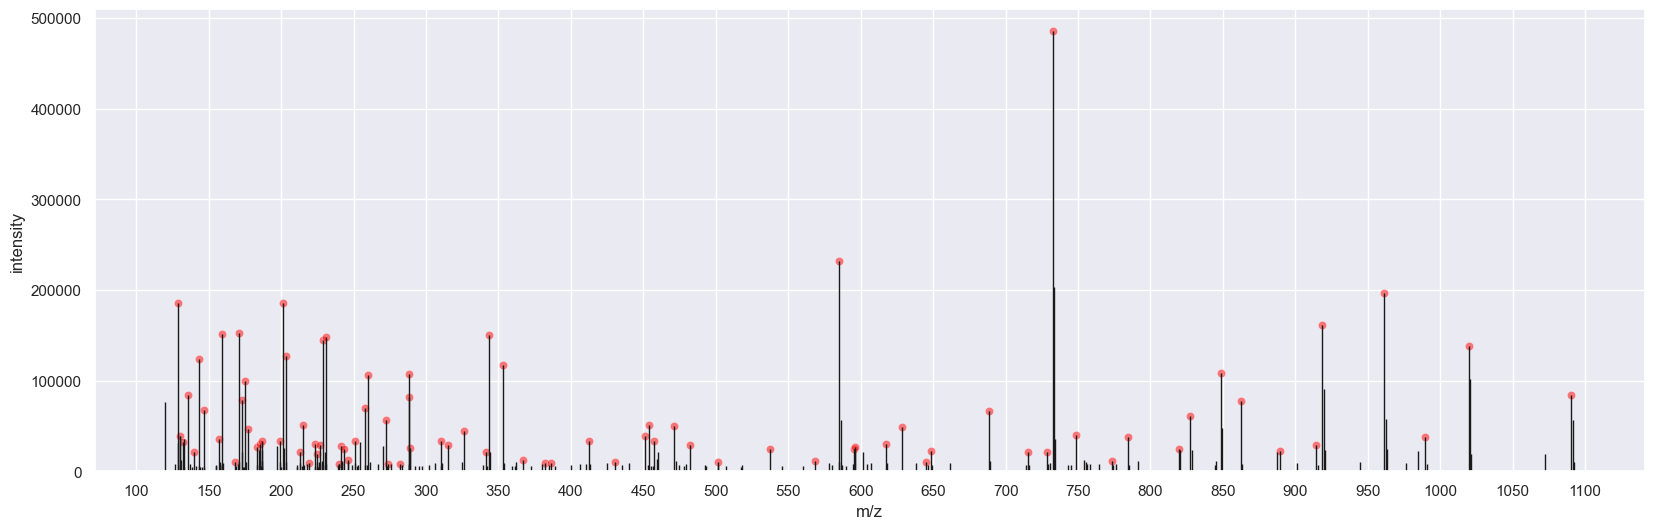

In [11]:
sp_height = None #intensity_array.max()*0.05
sp_dist = None
sp_prom = None
# avoiding early thresholding peter and kristoffer
# 5% of max height should be the cutoff threshold
# i.e.: based on how long we expect the amino acid sequence to be
# what determines wheter a peak is useful, is there someway we can find out?
#

sci_peak, _ = find_peaks(s1["intensity array"],
                      height=sp_height,
                      distance=sp_dist,
                      prominence=sp_prom
                      )
sns.set_theme(rc={'figure.figsize':(20,6)})
sns.scatterplot(data = s1.iloc[sci_peak].reset_index(),
                x = "m/z array",
                y = "intensity array",
                color = "red", alpha = 0.5).set_xticks(np.arange(0,1200,50))
pa.plot_spectrum(plotting_dict)
#plt.plot(np.zeros_like(x), "--", color="gray")
#plt.figure(figsize=(12,6))
plt.show()

## automatically annotating the spectra with pyteomics
based on the "real" peptide

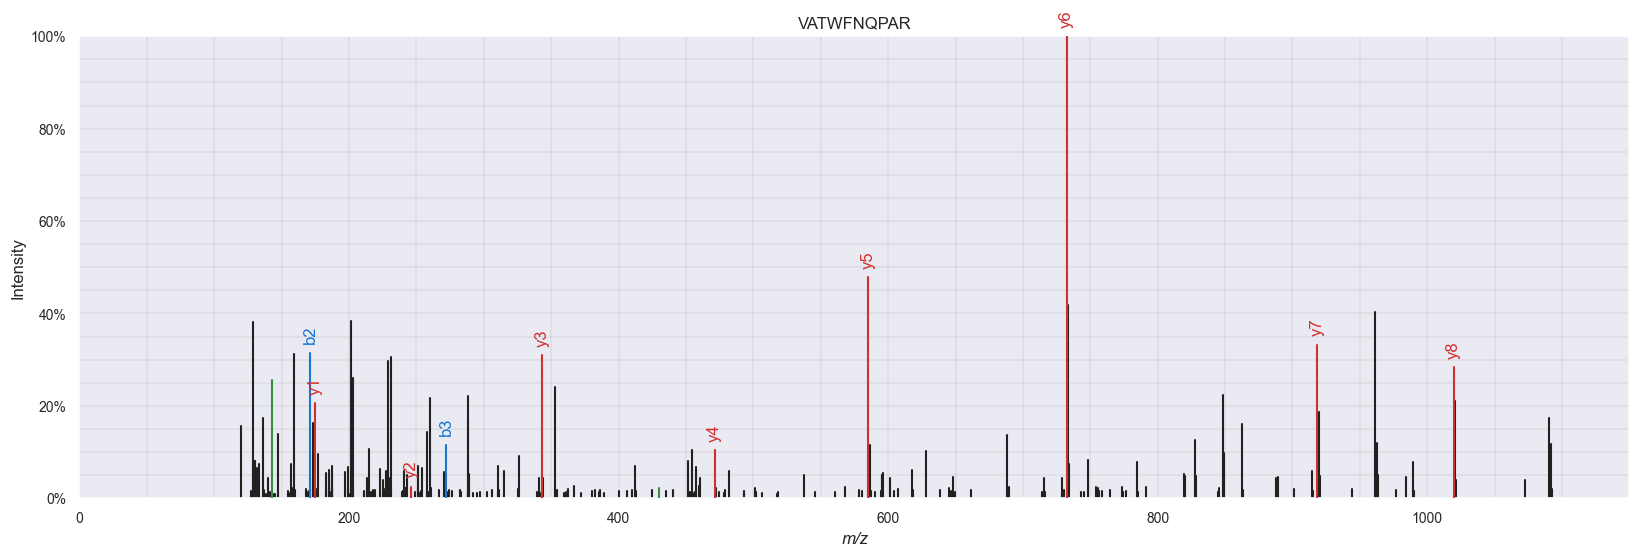

10

In [12]:
pa.annotate_spectrum(plotting_dict, peptide, precursor_charge=2, backend='spectrum_utils',
    ion_types='aby', title=peptide)
#plt.figure(figsize=(12,6))
plt.show()
len(peptide)

## Function for finding the closes amino acids

In [13]:
combo_df = aa

In [14]:
# the best threshold here would be 0.02 but I want to see how well the program works with 0.5 because I used 2.5 before
aa_thres = 0.05
def find_closest_aa(value, thres = aa_thres):
    """ Find the closest amino acid to a given mass.
    this code takes a dataframe with single amino acids and combinations of amino acids in this format

        full    letter  short   comp    mono    mass    G           A           S           P   V etc.
    0   glycine G       gly     c2h3no  57      57      g+g mass    g+a mass    g+s mass
    1   alanine A       ala     c3h5no  71      71      a+g mass    a+a mass    a+s mass
    etc.

    using this dataframe and a given mass, it will find the closest amino acid
     or combination of 2 amino acids to the given mass.
    It will only return amino acids that are within the threshold.
    It returns a list of lists, where each list contains the letter of the amino acid, its mass and the error.
    """
    if math.isnan(value) == True:
        return None
    single_df = combo_df.iloc[:,:-22]
    double_df = combo_df.set_index(["letter"]).iloc[
                :,[i for i in range(-22, -0)]]
    closeness_list = []
    # find the closest single amino acids
    loop_for_single = True
    while loop_for_single:
        aam_array = np.asarray(single_df["mono mass"])
        idx = (np.abs(aam_array - value)).argmin()
        error = np.abs(aam_array[idx] - value)
        if error > thres:
            loop_for_single = False
        else:
            name_idx = single_df["letter"].iloc[idx]
            closeness_list.append([name_idx, aam_array[idx], error])
            single_df = single_df.drop(single_df.index[idx])
    # find closest combination of amino acids
    loop_for_combo = True
    while loop_for_combo:
        error = (np.abs(double_df - value)).min().min()
        r, c = np.where(double_df == error + value)
        # if error wouldve been negative np.where will not find r, c
        # and pass empty arrays creating error
        if r.size == 0 :
            # print("boink")
            r, c = np.where(double_df == value - error)
        if error > thres:
            loop_for_combo = False
        else:
            name_idx = double_df.index[r[0]]+ double_df.columns[c[0]]
            closeness_list.append([name_idx, double_df.iloc[r[0],c[0]], error])
            double_df.iloc[r[0],c[0]] = None
    # print("closest aa is: ", name_idx, " ,with mass: ",
    # aam_array[idx], "Da. With an error of: ", error, "Da.")
    closeness_list.sort(key=lambda x: x[2])
    if closeness_list:
        # return closeness_list[0]
        return closeness_list[0][0]
    return None

# Cleaning Datasets for future steps
applying peak picking, rounding and adding missing values

In [15]:
mz_peaks = mz_array[sci_peak]
intensity_peaks = intensity_array[sci_peak]
# the precursor mass is not in the original mz_array or intensity_array dataset
# but since we know the precursor mass from the MS1 adding it makes our search easier
mz_peaks = np.append(mz_peaks,original_peptide_mass)
# I made the intensity of the manually added precursor max+1 so its the higest in the ranking
# this is because I think its always going to be part of the protein
intensity_peaks = np.append(intensity_peaks, intensity_peaks.max()+1)
# then another addition because at the C-terminus there is a water molecule and an extra proton
# it can be difficult to identify the last amino acid without using a little trick
# I will add another artificial peak at 19 Da to which the program can find a connected amino acid.
mz_peaks = np.append(19, mz_peaks)
# I had to append something at the 0th index and I choose the max intensity as well
# this time -0.5 instead of +1 because the +1 became the new max peak
# because the 19 Daltons should also always be there
intensity_peaks = np.append(intensity_peaks.max()-0.5,intensity_peaks)
mz_round = np.round(mz_peaks, decimals= 6)

## generate ground truth

In [16]:
# functions for automatically generating the groundtruth m/z values of peak from the known peptide sequence

def get_theoretical_y_ions(sequence):
    y_ions = []
    for i in range(1, len(sequence)+1):
        frag = sequence[-i:]
        mz = mass.fast_mass(frag, ion_type='y')
        y_ions.append(round(mz, 4)+1) # +1 because of extra proton charge
    return np.flip(y_ions).tolist()

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [17]:
real_sequence = []
real_peaks = []

for i in peptide:
    real_sequence.append(i)

for i in get_theoretical_y_ions(peptide):
    nearest = find_nearest(mz_round, i)
    real_peaks.append(nearest)


real_peptide = [real_sequence, real_peaks + [19]]

In [18]:
real_peptide

[['V', 'A', 'T', 'W', 'F', 'N', 'Q', 'P', 'A', 'R'],
 [1189.617184,
  1090.52832,
  1019.504089,
  918.458313,
  732.379272,
  585.310486,
  471.268768,
  343.207947,
  246.155853,
  175.119064,
  19]]

# Creating the distance Matrix

In [19]:
def rename(column):
    new = mz_round[int(column)]
    return new

In [20]:
# this code builds a distance matrix for the given mz_array
def build_dm():
    distance_matrix = []
    for column, i in zip(mz_round, range(len(mz_round))):
        distance_matrix.append([])
        for row in mz_round:
            distance_matrix[i].append(np.abs(row - column))

    df_dm = pd.DataFrame(distance_matrix)
    df_dm.columns = df_dm.columns.map(str)

    # for i in range(len(mz_round)):
    #     for j in range(i):
    #         df_dm.iat[i,j] = None
    for i in range(len(mz_round)):
        for j in range(len(mz_round)):
            if j >= i:
                df_dm.iat[i,j] = None
            if df_dm.iat[i,j] < 55 or df_dm.iat[i,j] > 480:
                df_dm.iat[i,j] = None

    # if j <= i:
    #     df_dm.iat[i,j] = None
    # drop columns with no values (all NaN)
    df_dm.dropna(axis = 1, how="all", inplace = True)

    print("starting mapping")
    df_aa = df_dm.map(find_closest_aa)
    print("mapping complete")


    #pavel pevzner
    df_aa.rename(columns=rename, inplace=True)
    df_aa.rename(index=rename, inplace=True)

    df_aa.to_csv(f"../distance_matrices/distance_matrix_{peptide}.csv")
    df_aa = pd.read_csv(f"../distance_matrices/distance_matrix_{peptide}.csv").set_index("Unnamed: 0")
    # suboptimal process but sadly I dont have the time to optimize this as I'd like.
    # I had this because I used the to_csv and read_csv functions when testing
    # and now I realized the csv thats being read is different to the one being written.
    # Because dictionaries get turned to strings.

    return df_aa


In [21]:
df_aa = build_dm()

starting mapping
mapping complete


## function to find all possible paths through this distance matrix


In [22]:
# pathfinding algorithm based on depth first search
def dfs(cur_peak, aa_path, peak_path, all_paths, mz_round, df_aa):
    """
    Recursively explores all valid peptide paths using depth-first search.

    Parameters:
    - cur_peak: current m/z value we're at
    - aa_path: list of amino acids collected so far
    - peak_path: list of m/z values used in the path
    - all_paths: master list of all complete peptide paths found
    - mz_round: full list/array of m/z peaks
    - df_aa: distance matrix with AA matches (rows and cols = m/z values)
    """
    try:
        peak_pos = np.where(mz_round == cur_peak)[0][0]
    except IndexError:
        return  # skip if cur_peak not in mz_round

    found = False

    for col in df_aa.columns:
        aa = df_aa[col].iloc[peak_pos]
        # print("aa",aa)
        if isinstance(aa, str):

            aa_list = aa.split('+')  # support combos like "G+P"
            # print("aa_list",aa_list)
            for aa_letter in aa_list:
                next_peak = float(col)
                if next_peak in peak_path:
                    continue  # avoid cycles

                # recurse to explore next peak
                dfs(
                    next_peak,
                    aa_path + [aa_letter],
                    peak_path + [next_peak],
                    all_paths,
                    mz_round,
                    df_aa
                )
                found = True

    if not found:
        # Dead end: store complete path
        all_paths.append((aa_path, peak_path))

In [23]:
all_paths = []
start_peak = float(mz_round[-1])  # typically highest m/z
dfs(start_peak, [], [start_peak], all_paths, mz_round, df_aa)

In [24]:
pep_df = pd.DataFrame(all_paths, columns = ["sequence","peaks"])
pep_df['len_pep'] = pep_df["peaks"].str.len()
pep_df.sort_values(by='len_pep', ascending=False)

,sequence,peaks,len_pep
248817,"[V, A, T, V, A, C, SS, Q, A, G, PV]","[1189.617184, 1090.52832, 1019.504089, 918.458...",12
244504,"[V, A, T, V, M, C, Q, A, K, A, AP]","[1189.617184, 1090.52832, 1019.504089, 918.458...",12
243443,"[V, A, T, V, GN, F, A, S, P, V, K]","[1189.617184, 1090.52832, 1019.504089, 918.458...",12
243441,"[V, A, T, V, GN, F, A, S, P, N, L]","[1189.617184, 1090.52832, 1019.504089, 918.458...",12
243439,"[V, A, T, V, GN, F, A, S, N, P, L]","[1189.617184, 1090.52832, 1019.504089, 918.458...",12
...,...,...,...
75,"[OO, ER, CK]","[1189.617184, 715.354675, 430.243988, 199.107712]",4
624,"[OO, VD, QO]","[1189.617184, 715.354675, 501.254547, 136.075653]",4
625,"[OO, VD, RW]","[1189.617184, 715.354675, 501.254547, 159.091644]",4
626,"[OO, VD, FW]","[1189.617184, 715.354675, 501.254547, 168.065216]",4


# implement confidence scoring function

## 1st intensity subscore or intensity rank sum

In [ ]:
ranked_intensity = np.flip(np.sort(intensity_peaks))

In [ ]:
def intensity_rank(peaks_list):
    rank_sum = 0
    for i in peaks_list:
        intensity = intensity_peaks[np.where(mz_round == i)[0][0]]
        # print(intensity, np.where(ranked_intensity == intensity)[0][0])
        # I added the + 1 so that the best rank is 1
        # I did this because the ChatGPT code did this too and I didnt want to mess it up lol
        rank_sum += np.where(ranked_intensity == intensity)[0][0] + 1
    return rank_sum

In [ ]:
def simulate_rank_sum_distribution(N, T, num_samples=1000000):
    rank_sums = []
    ranks = list(range(1, N+1))
    for _ in range(num_samples):
        sample = random.sample(ranks, T)
        rank_sums.append(sum(sample))
    return rank_sums

def empirical_p_value(observed_sum, distribution):
    # Probability of getting an equal or smaller sum by chance
    count = sum(1 for s in distribution if s <= observed_sum)
    return count / len(distribution)

In [26]:
# creating random rank distributions for each observed peptide length in the dataset

pep_lens_in_list = range(pep_df["len_pep"].min(),pep_df["len_pep"].max()+1)
rank_distributions = {}
for T in pep_lens_in_list:
    rank_distributions[T] = simulate_rank_sum_distribution(len(intensity_peaks), T)

In [ ]:
# applying the intensity rank functions to the entire dataframe

pep_df["rank_sum"] = pep_df["peaks"].apply(intensity_rank)
pep_df["rank_p"] = pep_df.apply(
lambda row: empirical_p_value(row["rank_sum"], rank_distributions[row["len_pep"]]),
axis=1
)

## 2nd m/z fidelity

In [ ]:
def find_SSE(sequence, peaks):
    # find the m/z fidelity from the first peak to the last
    # important here our first peak is the first y-ion so its already missing the first peptide
    estimation = []
    distance = 0
    for i in range(1,len(sequence)+1):
        if len(sequence[-i]) == 1:
            distance += aa[aa["letter"]==sequence[-i]]["mono mass"].sum()
        if len(sequence[-i]) == 2:
            distance += aa[aa["letter"]==sequence[-i][0]]["mono mass"].sum()
            distance += aa[aa["letter"]==sequence[-i][1]]["mono mass"].sum()
        estimation.append(peaks[-(i+1)] - distance)
    mean = np.mean(estimation)
    estimation = np.array(estimation)
    SSE = np.sum((estimation - mean) ** 2)

    return SSE


In [ ]:
# apply SSE to dataframe
pep_df["SSE"] = pep_df.apply(
lambda row: find_SSE(row["sequence"], row["peaks"]),
axis=1
)

In [74]:
def create_SSE_dist(n):
    SSE_distributions = {}
    dist = np.random.uniform(10-aa_thres,10+aa_thres,1000)
    for T in pep_lens_in_list:
        single_dist = []
        for i in range(n):
            estimation = []
            for i in range(T):
                estimation.append(random.choice(dist))
            mean = np.mean(estimation)
            estimation = np.array(estimation)
            SSE = np.sum((estimation - mean) ** 2)
            single_dist.append(SSE)
        SSE_distributions[T] = single_dist
    return SSE_distributions

In [75]:
SSE_len = 100000
SSE_distributions = create_SSE_dist(SSE_len)
def find_mz_fid_p(row):
    count = sum(1 for s in SSE_distributions[row["len_pep"]] if s <= row["SSE"])
    return (count / SSE_len) + 0.000001 # to avoid math errors when value is really low

In [76]:
# apply mz fidelity to dataframe

pep_df["mz_fid_p"] = pep_df.apply(
lambda row: find_mz_fid_p(row),
axis=1
)

## asses and combine confidence scores

In [78]:
def fisher_combined_p(p1, p2):
    """
    Combine two p-values using Fisher's method.
    """
    chi_stat = -2 * (math.log(p1) + math.log(p2))
    combined_p = chi2.sf(chi_stat, df=4)  # df = 2 * number of p-values
    return combined_p

In [ ]:
# apply fisher combined to dataframe

pep_df["combined_p"] = pep_df.apply(
lambda row: fisher_combined_p(row["rank_p"],row["mz_fid_p"]),
axis=1
)

In [79]:
pep_df

## discovering best fit peptide

In [81]:
# I assume the best fit peptide is in the top 20

top_20 = pep_df.sort_values(by=["combined_p"], ascending=True).reset_index()[0:20]

,sequence,peaks,len_pep,rank_sum,rank_p,SSE,mz_fid_p,combined_p
0,"[FO, WO]","[943.502572, 559.295715, 136.075821]",3,34,0.057147,0.000043,0.021501,0.009463
1,"[FO, FO, R]","[943.502572, 559.295715, 175.119186, 19.0]",4,41,0.018645,0.001349,0.275351,0.032199
2,"[FO, QO]","[943.502572, 559.295715, 194.091873]",3,60,0.336312,0.000043,0.021501,0.042876
3,"[FO, TO, TT]","[943.502572, 559.295715, 221.103302, 19.0]",4,47,0.034557,0.000082,0.006271,0.002045
4,"[FO, EW, PK]","[943.502572, 559.295715, 244.165649, 19.0]",4,64,0.131418,0.000051,0.003411,0.003904
...,...,...,...,...,...,...,...,...
1337,"[L, AV, T, S, AP, VW]","[943.502572, 830.4599, 660.330444, 559.295715,...",7,125,0.119448,0.000980,0.009241,0.008620
1338,"[L, AV, T, S, AP, AP]","[943.502572, 830.4599, 660.330444, 559.295715,...",7,130,0.152842,0.000980,0.009241,0.010681
1339,"[L, AV, T, S, AP, M]","[943.502572, 830.4599, 660.330444, 559.295715,...",7,136,0.200087,0.000980,0.009241,0.013485
1340,"[L, AV, T, S, AP, E, R]","[943.502572, 830.4599, 660.330444, 559.295715,...",8,137,0.072683,0.000984,0.003041,0.002081


In [ ]:
def num_doubles(str_list):
    counter = 0
    for i in str_list:
        if len(i) == 2:
            counter += 1
    return counter


In [101]:
# read double amino acids in a sequence

top_20["doubles"] = top_20.apply(
lambda row: num_doubles(row["sequence"]),
axis=1
)

# join the sequence list into a string

top_20["sequence"] = top_20.apply(
lambda row: "".join(row["sequence"]),
axis=1
)

In [102]:
counted_final = {i:top_20["sequence"].tolist().count(i) for i in top_20["sequence"].tolist()}
Best_fit_peptide = (top_20[top_20["sequence"] ==
       max(counted_final, key=counted_final.get)]
        .sort_values(by=["doubles"], ascending=True)
        .reset_index().iloc[0]
)

In [103]:
def I_to_L(sequence):
    for i in range(len(sequence)):
        if sequence[i] == "I":
            sequence[i] = "L"
    return sequence

In [119]:
real_peptide[0] = I_to_L(real_peptide[0])

In [124]:
def equality_check(a, b):
    equality_rank = 0
    if len(a) == len(b):
        for x, y in zip(a, b):
            if x == y:
                equality_rank += 1
            if x == y:
                pass
    else:
        print("peptides dont have same len")
    return equality_rank/len(a)


In [125]:
equality_check(Best_fit_peptide["sequence"], "".join(real_peptide[0]))

1.0